In [1]:
!pip install gensim spacy transformers chromadb sentence-transformers -q
# !python -m spacy download en_core_web_md -q
!pip install PyPDF2 pdfplumber

# ## In Colab: Restart session to avoid issues, specially with gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.1 MB/s eta 0

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec

import spacy

from transformers import AutoTokenizer, AutoModel
import torch
from torchinfo import summary
from torchviz import make_dot

import chromadb
from chromadb.utils import embedding_functions

import textwrap

from sentence_transformers import SentenceTransformer
import time

import nltk
# Download NLTK data quietly
nltk.download('punkt', quiet=True)  # Punkt tokenizer for sentence splitting
nltk.download('brown', quiet=True)  # Brown corpus for training data
from nltk.corpus import brown # for Word2Vec training with gensim





ModuleNotFoundError: No module named 'torchinfo'

##Word-Document and Word-Word Matrices

In [ ]:
# Example documents (Shakespeare plays)
documents = {
    "As You Like It": "battle good fool wit love forest magic",
    "Twelfth Night": "good fool wit love comedy mistaken identity",
    "Julius Caesar": "battle battle battle good fool war rome politics",
    "Henry V": "battle battle battle battle good wit war king england"
}

In [ ]:
def create_term_document_matrix(documents):
  """ Creates term-document matrix
  Rows represent words (terms)
  Columns represent docs
  Cells have the frequencies (counts)"""

  all_the_words = set()

  for doc in documents.values():
    all_the_words.update(doc.split())

  vocab = sorted(all_the_words)
  print(vocab)

  matrix = []

  for word in vocab:
    row = []

    for doc_name, doc_text in documents.items():
      count = doc_text.split().count(word)
      row.append(count)

    matrix.append(row)

  print(matrix)


  df = pd.DataFrame(matrix,
                    index=vocab,
                    columns=list(documents.keys()))

  return df

term_doc_matrix = create_term_document_matrix(documents)
print("\n", term_doc_matrix)

['battle', 'comedy', 'england', 'fool', 'forest', 'good', 'identity', 'king', 'love', 'magic', 'mistaken', 'politics', 'rome', 'war', 'wit']
[[1, 0, 3, 4], [0, 1, 0, 0], [0, 0, 0, 1], [1, 1, 1, 0], [1, 0, 0, 0], [1, 1, 1, 1], [0, 1, 0, 0], [0, 0, 0, 1], [1, 1, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 1], [1, 1, 0, 1]]

           As You Like It  Twelfth Night  Julius Caesar  Henry V
battle                 1              0              3        4
comedy                 0              1              0        0
england                0              0              0        1
fool                   1              1              1        0
forest                 1              0              0        0
good                   1              1              1        1
identity               0              1              0        0
king                   0              0              0        1
love                   1              1              0        0
magic 

## TF-IDF


In [ ]:
def compute_tf_idf(term_doc_matrix):
  """Compute Term Frequency × Inverse Document Frequency"""

  matrix = term_doc_matrix.values # Convert to numpy.ndarray to apply np.where easily

  n_docs = matrix.shape[1]

  print(np.where(matrix>0, 1,0))

  # Term freq
  tf = np.where(matrix > 0, 1 + np.log10(matrix + 1e-10), 0) # Raw counts can be misleading (100 occurrences isn't 100x more important than 1), for taht reason we compress it with the log10. Also, added small epsilon to avoid log(0) and warning
  print("\nTerm Freq:\n", tf, "\n")

  # Doc freq (words appearing on how many docs)
  df = np.sum(matrix>0, axis=1)
  print("\nDoc Freq:\n", df, "\n")

  # Inverse doc freq
  idf = np.log10(n_docs/df)
  print("\nInverse Doc Freq without log(10):\n", n_docs/df, "\n")

  print("\nInverse Doc Freq (with log(10)):\n", idf, "\n")


  # TF-IDF
  idf = idf[:, np.newaxis] # Flatten idf
  print("\nBroadcasted Inverse Doc Freq to dimensionality (n,1):\n", idf, "\n")

  tf_idf = tf*idf
  print("\nTF-IDF:\n", tf_idf, "\n")

  return pd.DataFrame(tf_idf, index=term_doc_matrix.index, columns=term_doc_matrix.columns)

tf_idf_matrix = compute_tf_idf(term_doc_matrix)
tf_idf_matrix

[[1 0 1 1]
 [0 1 0 0]
 [0 0 0 1]
 [1 1 1 0]
 [1 0 0 0]
 [1 1 1 1]
 [0 1 0 0]
 [0 0 0 1]
 [1 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 1]
 [1 1 0 1]]

Term Freq:
 [[1.         0.         1.47712125 1.60205999]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [1.         1.         1.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         1.         1.         1.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [1.         1.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         1.        ]
 [1.         1.         0.         1.        ]] 


Doc Freq:
 [3 1 1 3 1 4 1 1 2 1 1 1 1 2 3] 


Inverse Doc Freq without log(10):
 [1.33333333 4.         4.      

,As You Like It,Twelfth Night,Julius Caesar,Henry V
battle,0.124939,0.000000,0.184550,0.200159
comedy,0.000000,0.602060,0.000000,0.000000
england,0.000000,0.000000,0.000000,0.602060
fool,0.124939,0.124939,0.124939,0.000000
forest,0.602060,0.000000,0.000000,0.000000
good,0.000000,0.000000,0.000000,0.000000
identity,0.000000,0.602060,0.000000,0.000000
king,0.000000,0.000000,0.000000,0.602060
love,0.301030,0.301030,0.000000,0.000000
magic,0.602060,0.000000,0.000000,0.000000


## Word-Word Co-occurrence (Association)


In [ ]:
def create_word_cooccurrence_matrix(documents, window_size=2):
  cooccurrence = defaultdict(lambda: defaultdict(int))

  for doc in documents.values():
    words = doc.split()

    for i, target_word in enumerate(words):# print(i,target_word)

      start = max(0, i - window_size) # Sets the start of the context window so it is not below 0
      end = min(len(words), i + window_size + 1) # Sets the end of the context window so it is not above the last word
      print("Word ", target_word, "has a window with indexes range ", start, "-", end, "\n")

      for j in range(start,end):
        if i != j:                  # Not counting the word with itself

          context_word = words[j]
          cooccurrence[target_word][context_word] += 1

      print("cooccurrence: ", cooccurrence)


  # all_words = []
  # for doc in documents.values():
  #   for word in doc.split(): all_words.append(word)
  # sorted(set(all_words))

  all_words = sorted(set(word for doc in documents.values() for word in doc.split(" ")  )) # Same as above but in a set comprehension
  print("\nall_words: ", all_words)

  matrix = []
  for target_word in all_words:
    row = []
    for ctxt_word in all_words:
      row.append(cooccurrence[target_word][ctxt_word])
    matrix.append(row)

  return pd.DataFrame(matrix, index = all_words, columns = all_words)

cooc_matrix = create_word_cooccurrence_matrix(documents, window_size=2)
cooc_matrix

Word  battle has a window with indexes range  0 - 3 

cooccurrence:  defaultdict(<function create_word_cooccurrence_matrix.<locals>.<lambda> at 0x7f2ce829fba0>, {'battle': defaultdict(<class 'int'>, {'good': 1, 'fool': 1})})
Word  good has a window with indexes range  0 - 4 

cooccurrence:  defaultdict(<function create_word_cooccurrence_matrix.<locals>.<lambda> at 0x7f2ce829fba0>, {'battle': defaultdict(<class 'int'>, {'good': 1, 'fool': 1}), 'good': defaultdict(<class 'int'>, {'battle': 1, 'fool': 1, 'wit': 1})})
Word  fool has a window with indexes range  0 - 5 

cooccurrence:  defaultdict(<function create_word_cooccurrence_matrix.<locals>.<lambda> at 0x7f2ce829fba0>, {'battle': defaultdict(<class 'int'>, {'good': 1, 'fool': 1}), 'good': defaultdict(<class 'int'>, {'battle': 1, 'fool': 1, 'wit': 1}), 'fool': defaultdict(<class 'int'>, {'battle': 1, 'good': 1, 'wit': 1, 'love': 1})})
Word  wit has a window with indexes range  1 - 6 

cooccurrence:  defaultdict(<function create_word_co

,battle,comedy,england,fool,forest,good,identity,king,love,magic,mistaken,politics,rome,war,wit
battle,16,0,0,2,0,5,0,0,0,0,0,0,0,0,1
comedy,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
england,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
fool,2,0,0,0,0,3,0,0,2,0,0,0,1,1,2
forest,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
good,5,0,0,3,0,0,0,0,0,0,0,0,0,2,3
identity,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
king,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
love,0,1,0,2,1,0,0,0,0,1,1,0,0,0,2
magic,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


## PPMI (Positive Pointwise Mutual Information)

In [ ]:
def compute_ppmi(cooc_matrix, alpha = 0.75):
  """
  Compute PPMI matrix from the Co-occurrence matrix.
  alpha = 0.75: Levy et al. (2015) found that a setting of α = 0.75 improved performance of embeddings on a wide range of tasks
  0.75 increases the probability assigned to rare contexts, and hence lowers their PMI (Pα(c) > P(c) when c is rare).
  """

  matrix = cooc_matrix.values.astype(float)

  total = np.sum(matrix)


  # Joint probabilities P(w,c)
  # Element-wise division by scalar
  p_wc = matrix / total
  print("\n p_wc: \n", p_wc, "\n")

  # Getting marginal probabilities
  p_w = np.sum(matrix, axis=1) / total
  p_c = np.sum(matrix, axis=0) / total # Although it is the same bcs it is a symmetric co-occurrence matrix


  # Smoothing and re-normalizing
  p_c_alpha = np.power(p_c, alpha)
  p_c_alpha = p_c_alpha / np.sum(p_c_alpha)

  for i,j,k in zip(cooc_matrix.index, p_w, p_c_alpha):print(i,j,round(k,4)) ## p_w = p_c because it is a symmetric matrix, with the power to alpha that changes


  # Calculate PMI
  epsilon = 1e-10 #Added small epsilon to avoid division by zero and log(0)

  pmi = np.log2((p_wc + epsilon)/
              (p_w[:,np.newaxis] * p_c_alpha[np.newaxis,:]+epsilon)) # Broadcasting p_w to dimension (1,n)
  print("\n PMI: \n", pmi, "\n")

  # Convert to PPMI (turn negatives to zero)
  ppmi = np.maximum(0,pmi)
  return pd.DataFrame(ppmi, index=cooc_matrix.index, columns=cooc_matrix.columns)



ppmi_matrix = compute_ppmi(cooc_matrix, alpha = 0.75)
ppmi_matrix


 p_wc: 
 [[0.16 0.   0.   0.02 0.   0.05 0.   0.   0.   0.   0.   0.   0.   0.
  0.01]
 [0.   0.   0.   0.   0.   0.   0.01 0.   0.01 0.   0.01 0.   0.   0.
  0.01]
 [0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.01
  0.  ]
 [0.02 0.   0.   0.   0.   0.03 0.   0.   0.02 0.   0.   0.   0.01 0.01
  0.02]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.   0.   0.   0.
  0.01]
 [0.05 0.   0.   0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02
  0.03]
 [0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.
  0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01
  0.01]
 [0.   0.01 0.   0.02 0.01 0.   0.   0.   0.   0.01 0.01 0.   0.   0.
  0.02]
 [0.   0.   0.   0.   0.01 0.   0.   0.   0.01 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.01 0.   0.   0.   0.   0.01 0.   0.01 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01
  0.  ]
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.

,battle,comedy,england,fool,forest,good,identity,king,love,magic,mistaken,politics,rome,war,wit
battle,1.843331,0.000000,0.000000,0.000000,0.000000,0.828652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
comedy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.117016,0.000000,1.617016,0.000000,2.678294,0.000000,0.000000,0.000000,1.178294
england,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.678294,0.000000,0.000000,0.000000,0.000000,0.000000,2.617016,0.000000
fool,0.000000,0.000000,0.000000,0.000000,0.000000,1.217217,0.000000,0.000000,1.157584,0.000000,0.000000,0.000000,1.218862,0.157584,0.718862
forest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.032053,3.532053,0.000000,0.000000,0.000000,0.000000,1.593331
good,1.049782,0.000000,0.000000,1.156965,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.916576,1.062817
identity,0.000000,3.367016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.678294,0.000000,0.000000,0.000000,0.000000
king,0.000000,0.000000,3.532053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.032053,1.593331
love,0.000000,1.367016,0.000000,1.272442,1.678294,0.000000,0.000000,0.000000,0.000000,2.117016,1.678294,0.000000,0.000000,0.000000,1.178294
magic,0.000000,0.000000,0.000000,0.000000,3.678294,0.000000,0.000000,0.000000,2.617016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Cosine Similarity

In [ ]:
def cosine_similarity(vec1, vec2):
  """
  Compute cosine similarity between two vectors
  Dot product divide by the product of the Norms of both to normalize them
  cosine(v1, v2) = (v1 . v2) / (|v1| x |v1|)
  """

  dot_prod = np.dot(vec1, vec2)

  magnitude1 = np.sqrt(np.sum(vec1**2))
  magnitude2 = np.sqrt(np.sum(vec2**2))

  # Prevent div by zero
  if magnitude1 == 0 or magnitude2 == 0: return 0

  return np.dot(vec1,vec2)/ (magnitude1 * magnitude2)



### Usecase for Cosine Similarity

In [ ]:
def find_similar_words(word,matrix,top_n=3):
  """Finds the most similar words to a target word."""

  if word not in matrix.index:
    return([])

  target_vector = matrix.loc[word].values # Convert to pandas series
  similarities = []

  for other_word in matrix.index:
    if other_word != word:
      other_vector = matrix.loc[other_word].values
      sim = cosine_similarity(target_vector,other_vector)
      similarities.append((other_word, sim))

  similarities.sort(key=lambda x:x[1], reverse=True)  # Sort by similarity in descending order

  return similarities[:top_n]

find_similar_words('battle', tf_idf_matrix, 3)

[('war', 0.9081207804878239),
 ('england', 0.6681933257466228),
 ('king', 0.6681933257466228)]

##Simple Word2Vec Implementation (Skip-gram concept)

In [ ]:
def sigmoid(x):
    """Sigmoid activation function: σ(x) = 1 / (1 + e^(-x))"""
    return 1 / (1 + np.exp(-x))

In [ ]:
class SkipGram:
  """Simplified Skipgram"""

  def __init__(self, vocab_size, embedding_dim=10):
    # Random initialization multiplied by small value
    self.W = np.random.randn(vocab_size, embedding_dim) * 0.1
    self.C = np.random.randn(vocab_size, embedding_dim) * 0.1
    self.vocab_size = vocab_size

  def forward(self, target_idx, context_idx):
    "Conpute P(context_word|target_word)"

    # Get embeddings by indexing into matrices
    target_embedding = self.W[target_idx]
    context_embedding = self.C[context_idx]

    # Dot product and sigmoid
    dot_product = np.dot(target_embedding, context_embedding)
    probability = sigmoid(dot_product)

    return probability

  def train_pair(self, target_idx, context_idx, label, learning_rate=0.01):
    """
    Train on a single target-context pair.
    label: 1 for positive (real context), 0 for negative (noise)
    """

    # Forward pass
    prob = self.forward(target_idx, context_idx)

    gradient  = (prob-label) # derivative of loss w.r.t. activation

    # Store original values before updating
    w_original = self.W[target_idx].copy()
    c_original = self.C[context_idx].copy()

    # Update embeddings with gradient descent
    # ∂L/∂W[target] = gradient * C[context]
    self.W[target_idx] -= learning_rate * gradient * c_original
    self.C[context_idx] -= learning_rate * gradient * w_original

    print("")
    print(self.W[target_idx], self.C[target_idx] )
    print("")


### Usecase of SkipGram

In [ ]:
vocab = ['battle', 'good', 'fool', 'wit', 'love']

vocab_to_idx = {word: idx for idx,word in enumerate(vocab)}
print(vocab_to_idx)

model = SkipGram(len(vocab), embedding_dim=5)

print("\nTraining Skip-gram:")
print("Initial embedding for 'battle':", model.W[vocab_to_idx['battle']].round(3))


for _ in range(20):
  model.train_pair(vocab_to_idx['battle'], vocab_to_idx['good'], 1) # Positive example: 'battle' appears with 'good'
  model.train_pair(vocab_to_idx['battle'], vocab_to_idx['love'], 0) # Negative example: 'battle' doesn't appear with 'love'

print("Updated embedding for 'battle':", model.W[vocab_to_idx['battle']].round(3))


{'battle': 0, 'good': 1, 'fool': 2, 'wit': 3, 'love': 4}

Training Skip-gram:
Initial embedding for 'battle': [ 0.051  0.014 -0.137 -0.119 -0.133]

[ 0.05103227  0.0145106  -0.13710094 -0.11761859 -0.13316623] [ 0.02259421  0.0129427   0.07595019 -0.01104619  0.02594421]


[ 0.05081601  0.01444493 -0.13774327 -0.11723552 -0.13359638] [ 0.02233563  0.0128692   0.07665108 -0.01044965  0.02662401]


[ 0.05110116  0.01470047 -0.13742465 -0.11593757 -0.13341427] [ 0.02258791  0.01294177  0.07597263 -0.01102202  0.02596535]


[ 0.0508849   0.0146348  -0.13806696 -0.1155545  -0.13384441] [ 0.02232899  0.0128673   0.07667516 -0.01043404  0.0266464 ]


[ 0.05117009  0.01489037 -0.1377483  -0.11425638 -0.13366228] [ 0.02258165  0.01294083  0.07599502 -0.01099819  0.02598643]


[ 0.05095384  0.0148247  -0.1383906  -0.11387333 -0.13409242] [ 0.02232239  0.0128654   0.07669918 -0.01041878  0.02666872]


[ 0.05123907  0.01508031 -0.1380719  -0.11257504 -0.13391026] [ 0.02257541  0.01293987  0.076017

###  Visualization of Embeddings with t-SNE

Visualizing word embeddings from PPMI matrix
[[ 27.061226    19.571266  ]
 [ 41.878567   -13.310328  ]
 [ 42.025864    10.631084  ]
 [  5.84458      8.318714  ]
 [ 50.117714    -0.27983123]
 [ 29.434593     6.7900376 ]
 [ 29.489666   -19.734055  ]
 [ 13.671186    21.93513   ]
 [ 37.44587     -1.3878596 ]
 [ 17.967104    -1.2565985 ]
 [ 27.606993    -7.166381  ]
 [  6.0496125   -5.7165866 ]
 [ 18.413963    10.150228  ]
 [ 39.11019     22.808086  ]
 [ 16.349966   -15.06282   ]]


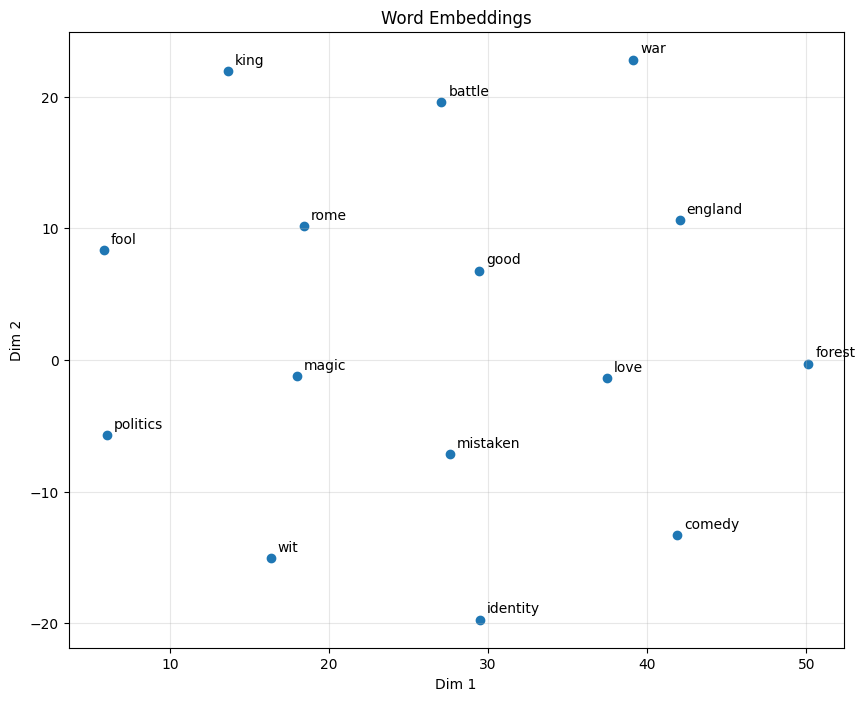

In [ ]:
def visualize_embeddings(embeddings, labels):
  """Visualize high-dimensional embedding in two dimensions with t-Distributed Stochastic Neighbor Embedding"""

  # Reducing dimensionality to 2 with t-SNE
  if embeddings.shape[1] > 2 and embeddings.shape[0] > 5: # Checking that there are enough samples
    # Adjust perplexity based on number of samples
    ppl = min(30,embeddings.shape[0]-1) # 30 is the default, but must be < n_samples
    tsne = TSNE(n_components = 2, random_state=42, perplexity=ppl)
    embeddings_2d = tsne.fit_transform(embeddings)
  else:
    embeddings_2d = embeddings[:,:2] # Takes just 2 first dimensions

  print(embeddings_2d)

  plt.figure(figsize=(10,8))
  plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])

  # Adding labels
  for i,label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), xytext=(5, 5), textcoords='offset points')

  plt.title("Word Embeddings")
  plt.xlabel("Dim 1")
  plt.ylabel("Dim 2")
  plt.grid(True, alpha=.3)
  plt.show()

if ppmi_matrix.shape[0]>0:
  print("Visualizing word embeddings from PPMI matrix")
  embeddings = ppmi_matrix.values
  labels = ppmi_matrix.index.tolist()
  visualize_embeddings(embeddings, labels)

### Word2Vec (with Gensim lib instead, common approach)


In [ ]:
# Using brown corpus
sentences = brown.sents()#[:10000]
print(sentences[:1000])

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]


In [ ]:
# Training Word2Vec
model = Word2Vec(
    sentences = sentences,
    vector_size = 100, # Embedding dimensionality
    window = 5,
    min_count = 5, # Ignoring words with frequency < 5
    workers = 4, # Parallel threads
    sg = 1, # Skip-gram (1) or Continuous Bag-of-Words (0)
    negative = 5, # Negative samples per each positive
    epochs = 10 # iters over the whole corpus
)

In [ ]:
print("\nMost similar words to 'man':")
similar_words = model.wv.most_similar('man', topn=5)
for word, similarity in similar_words:
    print(f"  {word}: {similarity:.3f}")
### Interesting results

print("\nMost similar words to 'Christ':")
similar_words = model.wv.most_similar('Christ', topn=5)
for word, similarity in similar_words:
    print(f"  {word}: {similarity:.3f}")




Most similar words to 'man':
  woman: 0.632
  boy: 0.622
  citizen: 0.599
  monk: 0.599
  guy: 0.598

Most similar words to 'Christ':
  Jesus: 0.825
  eternal: 0.804
  God: 0.800
  Son: 0.791
  Saviour: 0.762


In [ ]:
# Word analogies
print("\nWord analogy: father - man + woman = ?")
# positive: words to add, negative: words to subtract
result = model.wv.most_similar(positive=['father', 'woman'], negative=['man'], topn=1)
print(f"  Result: {result[0][0]} (similarity: {result[0][1]:.3f})")
# Probably needs more data in the corpus



Word analogy: father - man + woman = ?
  Result: mother (similarity: 0.720)


In [ ]:
# Word analogies
print("\nWord analogy: queen - woman + man = ?")
# positive: words to add, negative: words to subtract
result = model.wv.most_similar(positive=['queen', 'man'], negative=['woman'], topn=1)
print(f"  Result: {result[0][0]} (similarity: {result[0][1]:.3f})")



Word analogy: queen - woman + man = ?
  Result: presiding (similarity: 0.655)


### Visualization in 2D with PCA

word_vectors shpae: (26, 100)
word_vectors[:5,:5]: 
 [[ 0.04189809 -0.19704002  0.15089552  0.11237249  0.14436695]
 [ 0.2228708   0.11076368  0.49441546  0.29954737  0.03207644]
 [-0.00621594  0.04499584  0.07347209 -0.13069215  0.08310986]
 [-0.36987075  0.1555789   0.13787106  0.09389531  0.22582097]
 [ 0.28475466  0.05514208  0.23694187 -0.06801151  0.0141738 ]]
word_labels: 
 ['brave', 'fear', 'devil', 'hero', 'monster', 'doctor', 'faith', 'eternal', 'health', 'king', 'queen', 'man', 'woman', 'princess', 'boy', 'girl', 'father', 'mother', 'god', 'power', 'money', 'glory', 'God', 'Son', 'Jesus', 'Christ']
vectors_2d with PCA:
 [[ 3.4723446e-01 -5.5621654e-01]
 [-6.2840217e-01 -3.8991493e-01]
 [ 6.0459793e-02 -3.2063973e-01]
 [-1.7839107e-01  3.6523989e-01]
 [ 2.9235309e-01 -8.4042764e-01]
 [ 1.2630624e+00 -2.2122906e-01]
 [-1.0984217e+00 -3.4366462e-02]
 [-1.0092980e+00  1.3243965e-03]
 [ 4.0589109e-02 -1.6540844e+00]
 [-8.1661254e-02 -5.2211982e-01]
 [ 7.6459473e-01 -1.1590302e-01

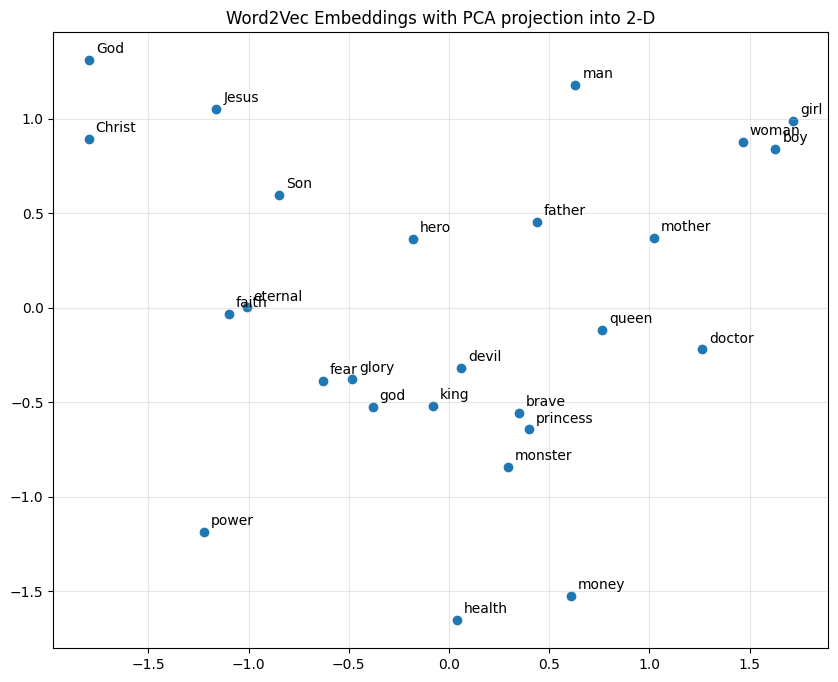

In [ ]:
def plot_word_vectors(model, words):
  """Plot word vectors in 2-D with Princpal Component Analysis"""

  word_vectors = np.array([model.wv[word] for word in words if word in model.wv])
  word_labels = [word for word in words if word in model.wv]

  print("word_vectors shpae:", word_vectors.shape)
  print("word_vectors[:5,:5]: \n", str(word_vectors[:5,:5]))
  print("word_labels: \n", word_labels)


  # Reducing dimensionality to just 2-D with PCA
  pca = PCA(n_components = 2)
  vectors_2d = pca.fit_transform(word_vectors)

  print("vectors_2d with PCA:\n", vectors_2d)

  # Plot
  plt.figure(figsize=(10,8))
  plt.scatter(vectors_2d[:,0], vectors_2d[:,1])
  plt.title("Word2Vec Embeddings with PCA projection into 2-D")
  plt.grid(True, alpha =.3)

  for i, word in enumerate(word_labels):
    plt.annotate(word, xy=(vectors_2d[i,0], vectors_2d[i,1]), xytext=(5, 5), textcoords='offset points')

  plt.show()

words_to_plot = ['brave', 'fear', 'devil', 'hero' ,'monster','doctor','faith', 'eternal', 'health','king', 'queen', 'man', 'woman', 'prince', 'princess', 'boy', 'girl', 'father', 'mother', 'god', 'noise_asdfasdf', 'power', 'money',  'glory', 'God', 'Son', 'Jesus', 'Christ']
plot_word_vectors(model, words_to_plot)


## TF-IDF with Scikit-learn

In [ ]:
# Sample documents
documents = [
    "The quick brown fox jumps over the lazy dog",
    "A quick brown dog outpaces a quick fox",
    "The lazy cat sleeps all day long",
    "Machine learning is fascinating and powerful",
    "Deep learning revolutionized natural language processing",
    "Natural language processing helps computers understand human language"
]

In [ ]:
# TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features = 100, # Max vocab size
    ngram_range = (1,2), # Use unigrams and bigrams (1-word and 2-word phrases)
    stop_words = 'english', # Removing English stopwords
    lowercase = True, # Converts to lowercase
    use_idf = True,   # IDF weighting
    smooth_idf = True, # Add-1 (Laplace) Smoothing
    sublinear_tf = True # Uses log(tf) instead of just tf
)

# vectorizer

# Fit and trasnform docs
tfidf_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

print("tfidf_matrix[1]\n")
for i in tfidf_matrix[1]: print(i)

print("feature_names:\n ",feature_names)

tfidf_df = pd.DataFrame(
  tfidf_matrix.toarray(),
  columns=feature_names,
  index=[f"Doc{i}" for i in range(len(documents))]
)

print("\ntfidf_df.iloc[1][:20]\n")
print(tfidf_df.iloc[1][:20])

print("TF-IDF Matrix shape:", tfidf_matrix.shape)
print("\nTop terms by TF-IDF score in first document:")
doc_tfidf = tfidf_df.iloc[0]  # First doc
top_terms = doc_tfidf.nlargest(5)  # Get 5 largest values
for term, score in top_terms.items():
  print(f"  {term}: {score:.3f}")




tfidf_matrix[1]

  (0, 41)	0.4477010965312605
  (0, 0)	0.264419479695321
  (0, 15)	0.264419479695321
  (0, 11)	0.264419479695321
  (0, 42)	0.264419479695321
  (0, 36)	0.3224571547338746
  (0, 1)	0.3224571547338746
  (0, 12)	0.3224571547338746
  (0, 37)	0.3224571547338746
  (0, 43)	0.3224571547338746
feature_names:
  ['brown' 'brown dog' 'brown fox' 'cat' 'cat sleeps' 'computers'
 'computers understand' 'day' 'day long' 'deep' 'deep learning' 'dog'
 'dog outpaces' 'fascinating' 'fascinating powerful' 'fox' 'fox jumps'
 'helps' 'helps computers' 'human' 'human language' 'jumps' 'jumps lazy'
 'language' 'language processing' 'lazy' 'lazy cat' 'lazy dog' 'learning'
 'learning fascinating' 'learning revolutionized' 'long' 'machine'
 'machine learning' 'natural' 'natural language' 'outpaces'
 'outpaces quick' 'powerful' 'processing' 'processing helps' 'quick'
 'quick brown' 'quick fox' 'revolutionized' 'revolutionized natural'
 'sleeps' 'sleeps day' 'understand' 'understand human']

tfidf_df

### Document similarity on the tfidf_matrix


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity # Cosine similarity from the lib

print("\nDocument similarity matrix:")
similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(
  similarity_matrix,
  index=[f"Doc{i}" for i in range(len(documents))],
  columns=[f"Doc{i}" for i in range(len(documents))]
)
print(similarity_df.round(3))

def find_similar_documents(doc_id, similarity_matrix, documents, top_n=2):
  """Find documents most similar to a given document."""
  similarities = similarity_matrix[doc_id]
  print("\nsimilarities:\n", similarities, "\n")

  similar_indices = np.argsort(similarities)[::-1][1:top_n+1] # argsort() returns indices that would sort array
  print("\nnp.argsort(similarities):", np.argsort(similarities), "\n")

  print(f"\nDocuments similar to: '{documents[doc_id]}'")
  for idx in similar_indices:
    print(f"  Similarity {similarities[idx]:.3f}: '{documents[idx]}'")


find_similar_documents(4, similarity_matrix, documents)


Document similarity matrix:
       Doc0   Doc1   Doc2   Doc3   Doc4   Doc5
Doc0  1.000  0.411  0.076  0.000  0.000  0.000
Doc1  0.411  1.000  0.000  0.000  0.000  0.000
Doc2  0.076  0.000  1.000  0.000  0.000  0.000
Doc3  0.000  0.000  0.000  1.000  0.087  0.000
Doc4  0.000  0.000  0.000  0.087  1.000  0.345
Doc5  0.000  0.000  0.000  0.000  0.345  1.000

similarities:
 [0.         0.         0.         0.08660601 1.         0.34514035] 


np.argsort(similarities): [0 1 2 3 5 4] 


Documents similar to: 'Deep learning revolutionized natural language processing'
  Similarity 0.345: 'Natural language processing helps computers understand human language'
  Similarity 0.087: 'Machine learning is fascinating and powerful'


# Embeddings with SpaCy (a bit more modern)

### Written in Cython, spaCy is optimized for performance, enabling fast processing of large volumes of text data.

In [ ]:
## !python -m spacy download en_core_web_md -q


# Load the model
nlp = spacy.load("en_core_web_md")
print(dir(nlp))

# Process text and get word vectors
text = "The quick brown fox jumps over the lazy dog"

doc = nlp(text)
print(doc)

print("spaCy Word Vectors:")
print(f"Vector dimension: {doc[0].vector.shape[0]}")  # First token's vector dimension


# Word similarity using spaCy
# Process individual words
word1 = nlp("king")
word2 = nlp("queen")
word3 = nlp("car")

print(f"\nWord similarities:")
# .similarity() method computes cosine similarity
print(f"  king - queen: {word1.similarity(word2):.3f}")
print(f"  king - car: {word1.similarity(word3):.3f}")

['Defaults', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_components', '_config', '_disabled', '_ensure_doc', '_ensure_doc_with_context', '_factory_meta', '_get_pipe_index', '_has_gpu_model', '_link_components', '_meta', '_multiprocessing_pipe', '_optimizer', '_path', '_pipe_configs', '_pipe_meta', '_resolve_component_status', 'add_pipe', 'analyze_pipes', 'batch_size', 'begin_training', 'component', 'component_names', 'components', 'config', 'create_optimizer', 'create_pipe', 'create_pipe_from_source', 'default_config', 'default_error_handler', 'disable_pipe', 'disable_pipes', 'disabled', 'enable_pipe', 'evaluate', 'factories', 'factory', 'fact

## Contextual Embeddings with Transformers (more modern)

In [ ]:
print("Loading BERT") # Requires using the HF_TOKEN, I have it loaded on colab
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name) # AutoTokenizer automatically loads the correct tokenizer for that model

model = AutoModel.from_pretrained(model_name) # AutoModel loads the model architecture and weights

# for i in dir(model):print(i)

# Key architecture details
print(f"Hidden size: {model.config.hidden_size}")
print(f"Num layers: {model.config.num_hidden_layers}")
print(f"Num attention heads: {model.config.num_attention_heads}")
print(f"Vocab size: {model.config.vocab_size}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\n========== LISTING THE LAYERS ========\n")
# List all layers
for name, module in model.named_modules():
    print(f"{name}: {module.__class__.__name__}")
print("\n==================\n")

print("\n")
print(model)

print("\n=== MODEL SUMMARY ===\n")
# Create actual input tensors for BERT
dummy_tokens = torch.randint(0, 1000, (1, 128))  # Random token IDs
summary(model, input_data={'input_ids': dummy_tokens},
        col_names=['input_size', 'output_size', 'num_params'],
        depth=3)
print("\n==================\n")

# Making downloadable viz of the arch of the model
print("\n=== CREATING COMPUTATION GRAPH ===\n")
dummy_input = tokenizer("Hello world", return_tensors="pt")
outputs = model(**dummy_input)
graph = make_dot(outputs.last_hidden_state.mean(), params=dict(model.named_parameters()))
graph.render("bert_graph", format="png")
print("Graph saved as bert_graph.png")



Loading BERT
Hidden size: 768
Num layers: 12
Num attention heads: 12
Vocab size: 30522
Total parameters: 109,482,240

========== LISTING THE LAYERS ========

: BertModel
embeddings: BertEmbeddings
embeddings.word_embeddings: Embedding
embeddings.position_embeddings: Embedding
embeddings.token_type_embeddings: Embedding
embeddings.LayerNorm: LayerNorm
embeddings.dropout: Dropout
encoder: BertEncoder
encoder.layer: ModuleList
encoder.layer.0: BertLayer
encoder.layer.0.attention: BertAttention
encoder.layer.0.attention.self: BertSdpaSelfAttention
encoder.layer.0.attention.self.query: Linear
encoder.layer.0.attention.self.key: Linear
encoder.layer.0.attention.self.value: Linear
encoder.layer.0.attention.self.dropout: Dropout
encoder.layer.0.attention.output: BertSelfOutput
encoder.layer.0.attention.output.dense: Linear
encoder.layer.0.attention.output.LayerNorm: LayerNorm
encoder.layer.0.attention.output.dropout: Dropout
encoder.layer.0.intermediate: BertIntermediate
encoder.layer.0.interm

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1793: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  result = forward_call(*args, **kwargs)





=== CREATING COMPUTATION GRAPH ===



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Graph saved as bert_graph.png


In [ ]:
def get_bert_embeddings(text):
  """ Get BERT embeddings for a text."""

  # tokenize and prepare inputs
  inputs = tokenizer(
    text,
    return_tensors="pt", # python tensors
    padding = True, # pads to same length
    truncation = True, # Truncates to max length
    max_length = 512
  )


  # Get token IDs and convert back to tokens
  token_ids = inputs['input_ids'][0]  # Get first sequence
  tokens = tokenizer.convert_ids_to_tokens(token_ids)
  for i in range(min(20, len(tokens))):
    print(f"{i}: {token_ids[i]:5d} -> '{tokens[i]}'")


  with torch.no_grad(): # inference mode to get embeddings, no need on computing gradients
    outputs = model(**inputs) # unpacking dicts as kwards


  # Extracting embeddings
  sentence_embedding = outputs.last_hidden_state[:, 0, :].numpy() # last_hidden_state shape: (batch_size, sequence_length, hidden_size). The [:, 0, :] selects CLS token (sentence representation)
  print("\nsentence_embedding[:,:10]\n")
  print(sentence_embedding[:,:10])
  print("\n")

  # Mean Pooling: averaging all the token embeddigns
  mean_embedding = outputs.last_hidden_state.mean(dim=1).numpy()
  print("\nmean_embedding[:,:10]\n")
  print(mean_embedding[:,:10])
  print("\n")

  return sentence_embedding[0], mean_embedding[0]


# Test sentences showcasing different linguistic phenomena
sentences = [
  # Polysemy: "bank" (financial vs. river)
  "The bank is by the river",
  "I need to go to the bank to deposit money",
  "The river bank is muddy",
  "She works at the central bank",
  "The boat docked at the river bank",
  "My bank account is overdrawn",

  # Polysemy: "bat" (animal vs. sports equipment)
  "The bat flew out of the cave at dusk",
  "She swung the bat and hit a home run",
  "Bats sleep hanging upside down",
  "He bought a new cricket bat",
  "The vampire bat feeds on blood",

  # Context changes meaning: "light"
  "The feather is very light",
  "Please turn on the light",
  "She wore a light blue dress",
  "Light travels faster than sound",
  "This suitcase feels light",
  "The room needs more light",

  # Synonyms in different contexts
  "The doctor prescribed medicine for my cold",
  "The physician recommended medication for my illness",
  "The surgeon performed the operation",
  "The medic treated the wounded soldier",

  # Idioms vs. literal meaning
  "It's raining cats and dogs outside",
  "The cats and dogs are playing together",
  "Break a leg at your performance tonight",
  "He literally broke his leg skiing",

  # Technical vs. common usage
  "I need to debug this Python code",
  "The bug crawled across the keyboard",
  "The software has a critical bug",
  "I found a bug in my salad"
]

embeddings = []

for sentence in sentences:
  cls_emb, mean_emb = get_bert_embeddings(sentence)
  embeddings.append(mean_emb)
  print(f"\nSentence: '{sentence}', with shape: {mean_emb.shape}. First 5 values: {mean_emb[:5].round(3)}.\n")

# Compute similarities
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(embeddings)

print("\nContextual similarity matrix:\n")
for i in range(len(sentences)):
  for j in range(i+1, len(sentences)):
    print(f" '{sentences[i]}' vs '{sentences[j]}':"
          f"{similarity_matrix[i,j]:.4f}" )

0:   101 -> '[CLS]'
1:  1996 -> 'the'
2:  2924 -> 'bank'
3:  2003 -> 'is'
4:  2011 -> 'by'
5:  1996 -> 'the'
6:  2314 -> 'river'
7:   102 -> '[SEP]'


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



sentence_embedding[:,:10]

[[-0.26922476  0.1791691   0.00322632 -0.21722725  0.19217332 -0.14972234
   0.25192466  0.40964547  0.00103763 -0.37182572]]



mean_embedding[:,:10]

[[-0.2837183  -0.02020967 -0.13097188 -0.15327573  0.3872578   0.03079577
   0.03031972  0.7190123   0.16200946 -0.4066363 ]]



Sentence: 'The bank is by the river', with shape: (768,). First 5 values: [-0.284 -0.02  -0.131 -0.153  0.387].

0:   101 -> '[CLS]'
1:  1045 -> 'i'
2:  2342 -> 'need'
3:  2000 -> 'to'
4:  2175 -> 'go'
5:  2000 -> 'to'
6:  1996 -> 'the'
7:  2924 -> 'bank'
8:  2000 -> 'to'
9: 12816 -> 'deposit'
10:  2769 -> 'money'
11:   102 -> '[SEP]'

sentence_embedding[:,:10]

[[ 0.36173242  0.46019268  0.10844228 -0.25013417 -0.05892862 -0.16726668
   0.24827677  0.2632707   0.19325846 -0.1615366 ]]



mean_embedding[:,:10]

[[ 0.42910492 -0.01528945  0.10143626  0.19277531  0.39588583 -0.4461132
   0.17052828  0.27796343  0.12179431 -0.12477583]]



Sentence: 'I need to go to the bank to deposit

##ChromaDB for Embedding Storage and Retrieval


In [ ]:
# Sample documents to index
documents = [
    "Machine learning is a subset of artificial intelligence",
    "Deep learning uses neural networks with multiple layers",
    "Natural language processing helps computers understand text",
    "Computer vision enables machines to interpret visual information",
    "Reinforcement learning trains agents through rewards and penalties",
    "Transfer learning reuses knowledge from pre-trained models",
    "Unsupervised learning finds patterns without labeled data",
    "Supervised learning requires labeled training examples"
]

In [ ]:
client = chromadb.PersistentClient(path="/content/chroma_db")  # Initialize persisting client

# Create embedding function
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
      model_name = "all-MiniLM-L6-v2")

# Create or get collections
try:
  collection = client.get_collection(
      name="document_embeddings",
      embedding_function = sentence_transformer_ef
      )
  print("Loading existing collection")
except Exception as e:
  collection = client.create_collection(
      name="document_embeddings",
      embedding_function = sentence_transformer_ef,
      metadata = {"description": "Document embedding for semantic search"}
  )
  print(f"Creating new collection: {e}")

# Check existence of docs before addign
existing_count = collection.count()
if existing_count == 0:
  # Adding if empty
  collection.add(         # In collection.add() uses plurals for the params
    documents = documents,
    metadatas = [{"source": f"doc_{i}", "category":"AI/ML"}
                for i in range(len(documents))],
    ids = [f"doc_{i}" for i in range(len(documents))]
  )
  print(f"Added {len(documents)} documents")
else:
  print(f"Collection already has {existing_count} documents")


# Perform semantic search
print("\nSemantic Search:\n")
query = "How do neural networks learn from examples?"
results = collection.query(    # query() finds most similar documents
    query_texts=[query],
    n_results = 3
)

for i, (doc, distance) in enumerate(zip(results['documents'][0], results['distances'][0])):
  print(f"{i+1}. Distance: {distance:.4f}. {doc}")

print("\n")

# Advanced search with metadata filtering
print("\n\nFiltered search (category='AI/ML'):\n")
filtered_results = collection.query(
    query_texts = ["What is learning without labels?"],
    n_results = 2,
    where = {"category": "AI/ML"} # Filtering by metadata
)

for doc, dist in zip(filtered_results['documents'][0], filtered_results['distances'][0]) : print(f"{dist:.4f} - {doc}")

Loading existing collection
Collection already has 8 documents

Semantic Search:

1. Distance: 0.9700. Deep learning uses neural networks with multiple layers
2. Distance: 1.0247. Supervised learning requires labeled training examples
3. Distance: 1.1870. Transfer learning reuses knowledge from pre-trained models




Filtered search (category='AI/ML'):

0.7620 - Supervised learning requires labeled training examples
0.8435 - Unsupervised learning finds patterns without labeled data


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


## Comparing Different Embedding Methods

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import time
import spacy

# Load required models
st_model = SentenceTransformer('all-MiniLM-L6-v2')

# Requires using the HF_TOKEN, I have it loaded on colab
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name) # AutoTokenizer automatically loads the correct tokenizer for that model

model = AutoModel.from_pretrained(model_name) # AutoModel loads the model architecture and weights


# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

# RENAME Word2Vec model to avoid conflict
from gensim.models import Word2Vec
sample_sentences = [["machine", "learning", "is", "great"],
                   ["computers", "process", "information", "fast"]]
w2v_model = Word2Vec(sentences=sample_sentences, vector_size=100, window=5, min_count=1)  # Changed name!


In [ ]:
def compare_embedding_methods(text):
  """Comparing different embedding methods for the same text"""

  results = {}

  # TF-IDF
  sample_docs = [text, "Just another document", "And one more as yapa"]
  tfidf_vec = TfidfVectorizer(max_features = 50) # Dimensions
  tfidf_matrix = tfidf_vec.fit_transform(sample_docs)
  results['TF-IDF'] = {
      'dimension': tfidf_matrix.shape[1],
      'type': 'sparse',
      'values': tfidf_matrix[0].toarray()[0][:5] # Just first 5 vals
  }


  # Word2Vec
  words = text.lower().split()
  valid_words = [w for w in words if w in w2v_model.wv] # Only existing words in the vocabulary
  if not valid_words:
    print(f"Warning: No valid words found for Word2Vec from: {words}")
  print("valid_words", valid_words)
  if valid_words:
    # Average word vectors
    w2v_embedding = np.mean([w2v_model.wv[w] for w in valid_words], axis = 0)
    results['Word2Vec'] = {
      'dimension': len(w2v_embedding),
      'type': 'dense',
      'values': w2v_embedding[:5] # Just first 5 vals
  }


  # spaCy
  spacy_doc = nlp(text)
  results['spaCy'] = {
    'dimension': len(spacy_doc.vector),
    'type': 'dense',
    'values': spacy_doc.vector[:5]
  }

  st_embedding = st_model.encode(text)
  results['Sentence-Transformer'] = {
    'dimension': len(st_embedding),
    'type': 'dense',
    'values': st_embedding[:5]
  }

  cls_emb, mean_emb = get_bert_embeddings(text)

  results['BERT'] = {
    'dimension': len(mean_emb),
    'type':'dense, contextual',
    'values': mean_emb[:5]
  }

  return results




# Compare diff methods
test_text = "Machine learning transforms how computers process information"
print(f"Comparing embeddings for: '{test_text}'\n")

comparison = compare_embedding_methods(test_text)
for method, info in comparison.items():
  print(f"{method}:")
  print(f"  Dimension: {info['dimension']}")
  print(f"  Type: {info['type']}")
  print(f"  First 5 values: {np.array(info['values']).round(3)}")
  print()

Comparing embeddings for: 'Machine learning transforms how computers process information'

valid_words ['machine', 'learning', 'computers', 'process', 'information']
TF-IDF:
  Dimension: 15
  Type: sparse
  First 5 values: [0.    0.    0.    0.378 0.   ]

Word2Vec:
  Dimension: 100
  Type: dense
  First 5 values: [-0.     0.001  0.001  0.002  0.003]

spaCy:
  Dimension: 96
  Type: dense
  First 5 values: [-0.057  0.164 -0.27   0.308  0.079]

Sentence-Transformer:
  Dimension: 384
  Type: dense
  First 5 values: [-0.035  0.039  0.025 -0.048  0.049]

BERT:
  Dimension: 768
  Type: dense, contextual
  First 5 values: [-0.072 -0.25  -0.257  0.105  0.29 ]



## Usecase: PDF Question Answering with Semantic Search

### Download chapter from the book


In [4]:
# !wget https://web.stanford.edu/~jurafsky/slp3/6.pdf # Easiest way

# More python way
import requests
url = "https://web.stanford.edu/~jurafsky/slp3/6.pdf"

resp = requests.get(url)

with open("6.pdf", "wb") as fh:
  fh.write(resp.content)



### Specific libs for this usecase

In [2]:
import PyPDF2
import pdfplumber # Better for complex pdfs
import re
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import textwrap

### Creating Class


In [43]:
class PDFSemanticSearch:
  """Semantic Search Engine for PDF documents."""

  def __init__(self, embedding_model='all-MiniLM-L6-v2'):
    self.model = SentenceTransformer(embedding_model)
    self. paragraphs = []
    self.embeddings = None
    self.metadata = []
    self.full_text = "" # Keeping the complete text for reference
    self.sections = []

  def extract_text_from_pdf(self,pdf_path):
    """PDF text extraction with multiple methods""" # using just PyPDF2 was not enough
    print(f"Reading PDF: {pdf_path}")
    all_text = []

    try:
      # Method 1: pdfplumber, better for complex layouts
      with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages):
          text = page.extract_text() or ""
          if text.strip():
            all_text.append({
                'text': text,
                'page': page_num + 1,
                'method': 'pdfplumber'
            })

    except Exception as e:
      print(f"pdfplumber failed :( \nError: {e} ")

    # Method 2: PyPDF2 as fallback if required
    if not all_text:
      print("Falling back to PyPDF2")
      with open(pdf_path, 'rb') as fh:
        pdf_reader = PyPDF2.PdfReader(fh)
        for page_num in range(len(pdf_reader.pages)):
          page = pdf_reader.pages[page_num]
          text = page.extract_text()
          if text.strip():
            all_text.append({
                'text': text,
                'page': page_num + 1,
                'method': 'PyPDF2'
            })

    # Store full text for reference
    self.full_text = "\n\n".join([page['text'] for page in all_text ])
    return(all_text)


  def clean_text(self, text):
    """Clean and normalize the extracted text."""

    # Common pdf extraction issues
    text = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', text) # Adding space btwn camelCase
    text = re.sub(r'(?<=[a-zA-Z])(?=[0-9])', ' ', text) # Add space between letter and number
    text = re.sub(r'(?<=[0-9])(?=[a-zA-Z])', ' ', text)
    text = re.sub(r'([a-z])([.!?,;:])([a-zA-Z])', r'\1\2 \3', text)  # Fix words that are concatenated with punctuation
    text = re.sub(r'\s+', ' ' , text) # Normalize whitespaces
    text = re.sub(r'(\w)-\s*\n\s*(\w)', r'\1\2', text) # Fixing hyphenated words
    text = re.sub(r'([.!?])\s*\n', r'\1 ', text)  # Fix sentence breaks

    # Remove excessive spaces but preserving paragraphs structure
    lines = text.split('\n')
    cleaned_lines = []
    for line in lines:
      line = line.strip()
      if line:
        cleaned_lines.append(line)

    return '\n'.join(cleaned_lines)


  def split_into_chunks(self, pdf_text, chunk_size=500, overlap=50):
    """
    Split text into overlapping chunks for context preservation.
    chunk_size: target size of each chunk in chars.
    overlap: number of chars to overlap between chunks.
    """
    chunks = []


    for page_data in pdf_text:
      text = self.clean_text(page_data['text'])
      page_num = page_data['page']

      # First try to split by paragraphs
      paragraphs = re.split(r'\n\s*\n|\n(?=[A-Z])', text)

      current_chunk = ""
      for para in paragraphs:
        para = para.strip()

        # if the paragraph is too long, split it further
        if len(para) > chunk_size:
          #split by sentencse
          sentences = re.split(r'(?<=[.!?])\s+', para)
          for sent in sentences:
            if len(current_chunk) + len(sent) > chunk_size and current_chunk:
              chunks.append({
                  'text': current_chunk.strip(),
                  'page': page_num,
                  'length': len(current_chunk)
              })
              # Keep overlap
              current_chunk = current_chunk[-overlap:] + " " + sent
            else:
              current_chunk += " " + sent

        # if adding paragraph does not exceed the chunk size
        elif len(current_chunk) + len(para) <= chunk_size:
          current_chunk += "\n" + para if current_chunk else para


        # If exceeds the chunk size, save current chunk and start a new one
        else:
          if current_chunk:
            chunks.append({
                'text': current_chunk.strip(),
                'page': page_num,
                'length': len(current_chunk)
            })
          current_chunk = para

      # Last chunk
      if current_chunk.strip():
          chunks.append({
              'text': current_chunk.strip(),
              'page': page_num,
              'length': len(current_chunk)
          })

    return chunks


  def extract_sections(self, text):
    """ Extract section headers and structure from text."""

    # Common section patterns for pdfs
    section_patterns = [
      r'^(\d+\.?\d*)\s+([A-Z][A-Za-z\s]+)$',  # Example: "6.1 Lexical Semantics"
      r'^([A-Z][A-Za-z\s]+):$',  # Example "Introduction:"
      r'^#{1,3}\s*(.+)$',  #  ###Markdown style headers
    ]

    sections = []
    for pattern in section_patterns:
      matches = re.finditer(pattern, text, re.MULTILINE) # re.MULTILINE modifies the behavior of the ^ (caret) and $ (dollar sign) anchors, acting also after the new lines \n
      for match in matches:
        sections.append({
          'title': match.group(0).strip(),
          'start': match.start(),
          'level': match.group(1) if match.lastindex > 1 else '0'
        })

    return(sorted(sections, key=lambda x: x['start']))



  def index_pdf(self, pdf_path, chunk_size=500):
    """Extract and index chunks from the pdf with processing"""

    # Extract text from the pdf
    pdf_text = self.extract_text_from_pdf(pdf_path)

    if not pdf_text:
      raise ValueError("No text could be extracted from the PDF.")


    # Extract sections for better context
    self.sections = self.extract_sections(self.full_text)
    print(f"Found {len(self.sections)} sections in the document")

    # Split into chunks
    chunk_data = self.split_into_chunks(pdf_text, chunk_size=chunk_size)

    # Extract text and metadata
    self.paragraphs = [c['text'] for c in chunk_data]
    self.metadata = []

    for i, chunk in enumerate(chunk_data):
      # Find which section this chunk belongs to
      chunk_start = self.full_text.find(chunk['text'][:50])
      section = "Unknown"
      for s in reversed(self.sections):
        if s['start'] <= chunk_start:
          section = s['title']
          break

      self.metadata.append({
          'page': chunk['page'],
          'length': chunk['length'],
          'section': section,
          'index': i
      })

    print(f"\nCreated {len(self.paragraphs)} chunks")
    print(f"Average chunk size: {np.mean([m['length'] for m in self.metadata]):.0f} characters")
    print("Creating embeddings...")

    # Create the embeddings
    self.embeddings = self.model.encode(
        self.paragraphs,
        show_progress_bar = True,
        batch_size = 32,
        convert_to_numpy=True
    )

    print("Indexing complete!")

  def search(self, query, top_k=5, threshold=0.25, rerank=True):
    """Search with optional reranking"""

    if self.embeddings is None:
      raise ValueError("No documents indexed. Use index_pdf() first.")


    # Encode query
    query_embedding = self.model.encode([query], convert_to_numpy=True) # np.argsort(similarities) - Gets indices that would sort the array (ascending). top_k*2 candidates if reranking is enabled (to have more options for reranking), so if top_k=5 and rerank=True, it gets the indices of the 10 most similar chunks, which will later be reranked and trimmed to 5.

    # Compute similarities
    similarities = cosine_similarity(query_embedding, self.embeddings)[0]

    # Get top candidates
    top_indices = np.argsort(similarities)[::-1][:top_k*2 if rerank else top_k]

    results = []
    for idx in top_indices:
      score = similarities[idx]
      if score >= threshold:
        results.append({
            'paragraph': self.paragraphs[idx],
            'score': score,
            'page': self.metadata[idx]['page'],
            'section': self.metadata[idx]['section'],
            'index':idx
        })

    # Rerank based on additional factors
    if rerank and results:
      results = self._rerank_results(results, query)

    return(results[:top_k])

  def _rerank_results(self, results, query):
    """Rerank results based on additional criteria: exact matches in the text/section/title."""

    query_terms = set(query.lower().split())  # LowerCase and split to match exactly the query with the text

    for result in results:
      text_lower = result['paragraph'].lower() # LowerCase to match exactly the query with the text

      # Boost score for exact term matches
      term_matches = sum(1 for term in query_terms if term in text_lower)

      # Boost for title/section matches
      section_boost = 0.1 if any(term in result['section'].lower()
                                for term in query_terms) else 0

      # Combine scores
      result['final_score'] = result['score'] + (term_matches * 0.05) + section_boost

    # Sort by final score
    return sorted(results, key=lambda x: x['final_score'], reverse=True)

  def answer_question(self, question, top_k=3, show_context=True):
    """ Question answering"""

    print(f"\n{'='*80}")
    print(f"Question: {question}")
    print(f"{'='*80}\n")

    # Searching for relevant chunks
    results = self.search(question, top_k=top_k)

    if not results:
      print("No relevant content found. Review your question, pal.")
      return None

    print(f"Found {len(results)} relevant passages:\n")

    # Display results
    for i, result in enumerate(results, 1):
      print(f"Result {i} (Page {result['page']}, Score: {result['score']:.3f})")
      print(f"Section: {result['section']}")
      print("-" * 60)

      # Format and display text
      text = result['paragraph']

      # Highlight query terms
      highlighted_text = self._highlight_terms(text, question)

      # Wrap text for better readability
      wrapped_lines = textwrap.wrap(highlighted_text, width=80)
      for line in wrapped_lines:
          print(line)

      print("\n")

      # Show surrounding context if requested
      if show_context and i==1: # For the top result only
        self._show_context(result['index'])


    return(results)

  def _highlight_terms(self, text, query):
    """Highlight query terms in text."""
    # Extract important terms from query
    stop_words = {'what', 'is', 'the', 'how', 'does', 'are', 'in', 'of', 'to', 'a', 'an'}
    query_terms = [term.lower() for term in query.split()
                  if term.lower() not in stop_words and len(term) > 2]

    # Highlight each term
    for term in query_terms:
      # Case-insensitive replacement with word boundaries
      pattern = re.compile(rf'\b{re.escape(term)}\b', re.IGNORECASE)
      text = pattern.sub(lambda m: f"**{m.group().upper()}**", text)

    return text

  def _show_context(self, index, window=1):
    """Show surrounding context for a result."""
    print("\n Extended Context:")
    print("-" * 60)

    # Get surrounding chunks
    start_idx = max(0, index - window)
    end_idx = min(len(self.paragraphs), index + window + 1)

    for i in range(start_idx, end_idx):
      if i == index:
        print(">>> MAIN PASSAGE <<<")
      else:
        print(f"[Context from page {self.metadata[i]['page']}]")

      wrapped = textwrap.wrap(self.paragraphs[i], width=80)

      for line in wrapped[:3]:  # Show first 3 lines of context
        print(line)
      if len(wrapped) > 3:
        print("...")
      print()

  def get_section_summary(self):
    """Get a summary of document sections."""
    if not self.sections:
      return "No sections found."

    print("\n Document Structure:")
    print("=" * 60)

    current_level = None
    for section in self.sections[:20]:  # Show first 20 sections
      level = section.get('level', '0')
      indent = "  " * (len(level.split('.')) - 1)
      print(f"{indent}{section['title']}")

    if len(self.sections) > 20:
      print(f"... and {len(self.sections) - 20} more sections")



# Create enhanced search engine
pdf_search = PDFSemanticSearch()

# Index the PDF
pdf_path = "6.pdf"
pdf_search.index_pdf(pdf_path, chunk_size=600)

# Show document structure
pdf_search.get_section_summary()

Reading PDF: 6.pdf
Found 18 sections in the document

Created 224 chunks
Average chunk size: 489 characters
Creating embeddings...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Indexing complete!

 Document Structure:
6 Vector Semantics and
Embeddings
  6.1 Lexical Semantics
  6.2 Vector Semantics
Andsupposethatyouhadseenmanyofthesecontextwordsinothercontexts:
  6.3 Words and Vectors
  6.4 Cosine for measuring similarity
10
Notethattheidfweightinghaseliminatedtheimportanceoftheubiquitouswordgoodand
Wemodeltheprobabilitythatwordcisarealcontextwordfortargetwordwas:
  6.9 Visualizing Embeddings
DOG
CAT
TURTLE
PKUIPTPTYEN COW LION NASHVILLE
  6.10 Semantic properties of embeddings
Inthissectionwebrieflysummarizesomeofthesemanticpropertiesofembeddings
# » # » # »
# »
# » # » # » # »
# » # » # » # » # » # »
# »
# » # » # » # »
  6.12 Evaluating Vector Models
The most important evaluation metric for vector models is extrinsic evaluation on
  6.13 Summary


In [44]:
# Interactive mode with improved features
def enhanced_interactive_qa():
  """Enhanced interactive Q&A with helpful features."""
  print("\n" + "="*80)
  print(" Enhanced PDF Q&A System")
  print(" Commands: 'help', 'sections', 'search [term]', 'quit'")
  print("="*80)

  while True:
    user_input = input("\nAsk a question (or command): ").strip()

    if user_input.lower() in ['quit', 'exit', 'q']:
      print("Goodbye!")
      break

    elif user_input.lower() == 'help':
      print("\nAvailable commands:")
      print(" - Ask any question about the content")
      print(" - 'sections': Show document structure")
      print(" - 'search [term]': Search for specific term")
      print(" - 'quit': Exit the system")

    elif user_input.lower() == 'sections':
      pdf_search.get_section_summary()

    elif user_input.lower().startswith('search '):
      search_term = user_input[7:]
      print(f"\nSearching for '{search_term}'...")
      results = pdf_search.search(search_term, top_k=3)
      if results:
        print(f"Found {len(results)} results containing '{search_term}'")
        for i, r in enumerate(results, 1):
          print(f"\n{i}. Page {r['page']}, Section: {r['section']}")
          print(f" Preview: {r['paragraph'][:100]}...")

    elif user_input:
      pdf_search.answer_question(user_input)

    else:
      print("Please enter a question or command.")

# Run enhanced interactive mode
enhanced_interactive_qa()

# Example questions about Chapter 6 content
questions = [
    "What is the distributional hypothesis?",
    "How does Word2Vec skip-gram work?",
    "What is the difference between sparse and dense embeddings?",
    "How do we compute cosine similarity between vectors?",
    "What is PPMI and how is it calculated?",
    "What are the problems with bias in embeddings?",
    "How does TF-IDF weighting work?"
]



 Enhanced PDF Q&A System
 Commands: 'help', 'sections', 'search [term]', 'quit'

Ask a question (or command): What are the problems with bias in embeddings?

Question: What are the problems with bias in embeddings?

Found 3 relevant passages:

Result 1 (Page 27, Score: 0.571)
Section: Unknown
------------------------------------------------------------
nenand Goldberg,2019),andthisremainsanopenproblem. Historical embeddings are
also being used to measure biases in the past. Garg et al. (2018) used
embeddings from historical texts to measure the association be- tween embeddings
for occupations and embeddings for names of various ethnici-
tiesorgenders(forexampletherelativecosinesimilarityofwomen’snamesversus men’s to
occupation words like ‘librarian’ or ‘carpenter’) across the 20 th century. They
found that the cosines correlate **WITH** the empirical historical percentages
of women or ethnic groups in those occupations.



 Extended Context:
-------------------------------------------

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Question: How do we compute cosine similarity between vectors?

Found 3 relevant passages:

Result 1 (Page 11, Score: 0.628)
Section: Unknown
------------------------------------------------------------
ultthatseemssensible. Fig.6.8 showsavisualization. 500 cherry digital
information 500 1000 1500 2000 2500 3000 ’eip‘ :1 noisnemi D Dimension 2:
‘computer’ Figure 6.8 A (rough) graphical demonstration of **COSINE**
**SIMILARITY**, showing vectors for threewords(cherry, digital,
andinformation)inthetwodimensionalspacedefinedbycounts
ofthewordscomputerandpienearby. Thefiguredoesn’tshowthecosine,
butithighlightsthe angles;
notethattheanglebetweendigitalandinformationissmallerthantheanglebetween
cherryandinformation.



 Extended Context:
------------------------------------------------------------
[Context from page 11]
-negative, thecosineforthesevectorsrangesfrom 0–1.
Let’sseehowthecosinecomputeswhichofthewordscherryordigitaliscloser
inmeaningtoinformation, justusingrawcountsfromthefollo

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Question: How does Word2Vec skip-gram work?

Found 3 relevant passages:

Result 1 (Page 19, Score: 0.681)
Section: Unknown
------------------------------------------------------------
ftheembeddingsofthetargetword witheachcontextword. Tocomputethisprobability,
wejustneedembeddingsfor eachtargetwordandcontextwordinthevocabulary. Fig. 6.13
shows the intuition of the parameters we’ll need. **SKIP-GRAM** actually
storestwoembeddingsforeachword, oneforthewordasatarget, andoneforthe
wordconsideredascontext. Thustheparametersweneedtolearnaretwomatrices W and C,
each containing an embedding for every one of the |V| words in the vocabulary
V.6 Let’snowturntolearningtheseembeddings(whichistherealgoal
oftrainingthisclassifierinthefirstplace).



 Extended Context:
------------------------------------------------------------
[Context from page 19]
word, but there are many context wordsinthewindow. Skip-
grammakesthesimplifyingassumptionthatallcontext wordsareindependent,
allowingustojustmultiplyt

KeyboardInterrupt: Interrupted by user